# Assignment II - Deep Learning for Computer Vision
## Dalia Smyrnov and Michael Rubinfeld

In this assignment we will try to classify cats and dogs images with CNN and transfer learning methods.
lets start by import necessary packages.

In [ ]:
# make sure GPU works
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/My\ Drive/ex_2/cats_and_dogs_data.zip

Archive:  drive/My Drive/ex_2/cats_and_dogs_data.zip
   creating: content/data/
  inflating: content/data/X_train.npy  
  inflating: content/data/Y_test.npy  
  inflating: content/data/Y_train.npy  
  inflating: content/data/X_test.npy  


In [ ]:
from keras import backend as K
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [ ]:
X_train = np.load('/content/content/data/X_train.npy')
Y_train = np.load('/content/content/data/Y_train.npy')
X_test = np.load('/content/content/data/X_test.npy')
Y_test = np.load('/content/content/data/Y_test.npy')

## Explore the data

We can see that each sample is an image of size 180x180 pixels. the images are RGB.

In [ ]:
# explore data
print("Shape of the data:", X_train.shape)
print("Unique labels:", np.unique(Y_train))

Shape of the data: (3200, 180, 180, 3)
Unique labels: [0. 1.]


<Figure size 432x288 with 0 Axes>

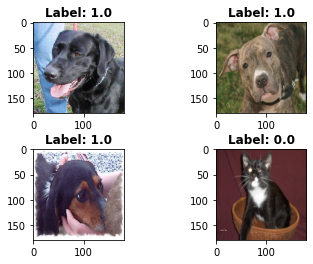

In [ ]:
def plot_random_samples(x, y):
  plt.figure()

  f, axarr = plt.subplots(2, 2, gridspec_kw={'hspace':0.4}) 
  rands = np.random.randint(x.shape[0], size=4)
  axarr[0, 0].imshow(x[rands[0], :, :].astype(np.uint8))
  axarr[0, 0].set_title('Label: ' + str(y[rands[0]]), fontweight='bold')

  axarr[1, 0].imshow(x[rands[1], :, :].astype(np.uint8))
  axarr[1, 0].set_title('Label: ' + str(y[rands[1]]), fontweight='bold')

  axarr[0, 1].imshow(x[rands[2], :, :].astype(np.uint8))
  axarr[0, 1].set_title('Label: ' + str(y[rands[2]]), fontweight='bold')

  axarr[1, 1].imshow(x[rands[3], :, :].astype(np.uint8))
  axarr[1, 1].set_title('Label: ' + str(y[rands[3]]), fontweight='bold')

  plt.show()

plot_random_samples(X_train, Y_train)

There are 2 label classes: 1 - dog , 0 - cat.

Also, we will normalize the data by dividing the it with the maximal value of pixels:

In [ ]:
# normalization
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
# Split train test
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)
print('Shape of x_train is:', X_train.shape)
print('Shape of y_train is:', Y_train.shape)
print('Shape of x_test is:', X_test.shape)
print('Shape of y_test is:', Y_test.shape)
print('Shape of x_val is:', X_val.shape)
print('Shape of y_val is:', Y_val.shape)

Shape of x_train is: (2560, 180, 180, 3)
Shape of y_train is: (2560,)
Shape of x_test is: (800, 180, 180, 3)
Shape of y_test is: (800,)
Shape of x_val is: (640, 180, 180, 3)
Shape of y_val is: (640,)


In [ ]:
def run_model(model, batch_size, epoches):

  model.compile(loss='binary_crossentropy', optimizer=Adam(1e-5), metrics=['accuracy'])

  es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=5, mode='max')
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, mode='max',min_lr=1e-7, verbose=1)

  AMOUNT_OF_TRAIN_DATA = X_train.shape[0]
  AMOUNT_OF_VALIDATION_DATA = X_val.shape[0]

  history = model.fit(
      X_train,Y_train,
      validation_data=(X_val, Y_val),
      steps_per_epoch=AMOUNT_OF_TRAIN_DATA // batch_size,
      epochs=epoches,
      validation_steps=AMOUNT_OF_VALIDATION_DATA // batch_size,
      callbacks=[es, reduce_lr],
      shuffle=True)
  
  return history


def plot_training_graph(history):
  plt.figure(figsize=(15,10))
  plt.subplot(1, 2, 1) # row 1, col 2 index 1
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper right')

  plt.subplot(1, 2, 2) # index 2
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')

  plt.show()

## Part 1 - Basic CNN Model

This basic model will contain four 2d convolutional layers followed by two fully connected layer (one hidden layer and one output layer). Between these hidden layers we have added dropout, max-pooling and batch normalization for regularization and dimensionality reduction.

In [ ]:
basic_cnn_model = keras.Sequential()
basic_cnn_model.add(Conv2D(16, (3,3), input_shape=(180,180,3)))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Activation('relu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(2,2)))

basic_cnn_model.add(Conv2D(32, (3,3)))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Activation('relu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(2,2)))

basic_cnn_model.add(Conv2D(32, (3,3)))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Activation('relu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(2,2)))

basic_cnn_model.add(Conv2D(64, (3,3)))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Activation('relu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(2,2)))

basic_cnn_model.add(Flatten())

basic_cnn_model.add(Dense(128))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Activation('relu'))

basic_cnn_model.add(Dropout(0.3))
basic_cnn_model.add(Dense(1))
basic_cnn_model.add(Activation('sigmoid'))
basic_cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 178, 178, 16)      448       
                                                                 
 batch_normalization_12 (Bat  (None, 178, 178, 16)     64        
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 178, 178, 16)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 16)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 32)        4640      
                                                                 
 batch_normalization_13 (Bat  (None, 87, 87, 32)      

Epoch 1/30
160/160 [==============================] - 7s 35ms/step - loss: 0.7629 - accuracy: 0.5621 - val_loss: 0.7160 - val_accuracy: 0.5141 - lr: 1.0000e-05
Epoch 2/30
160/160 [==============================] - 5s 31ms/step - loss: 0.7162 - accuracy: 0.5945 - val_loss: 0.6970 - val_accuracy: 0.5547 - lr: 1.0000e-05
Epoch 3/30
160/160 [==============================] - 5s 32ms/step - loss: 0.6754 - accuracy: 0.6293 - val_loss: 0.6475 - val_accuracy: 0.6156 - lr: 1.0000e-05
Epoch 4/30
160/160 [==============================] - 5s 33ms/step - loss: 0.6380 - accuracy: 0.6527 - val_loss: 0.6276 - val_accuracy: 0.6266 - lr: 1.0000e-05
Epoch 5/30
160/160 [==============================] - 5s 33ms/step - loss: 0.6128 - accuracy: 0.6613 - val_loss: 0.6306 - val_accuracy: 0.6422 - lr: 1.0000e-05
Epoch 6/30
160/160 [==============================] - 5s 34ms/step - loss: 0.5951 - accuracy: 0.6848 - val_loss: 0.6445 - val_accuracy: 0.6453 - lr: 1.0000e-05
Epoch 7/30
160/160 [====================

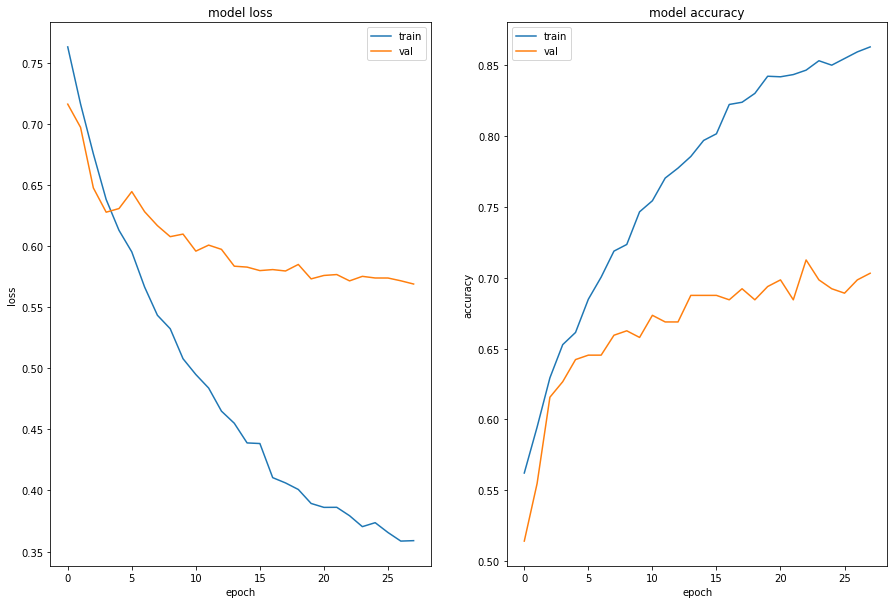

In [ ]:
basic_cnn_history = run_model(basic_cnn_model, 16, 30)
plot_training_graph(basic_cnn_history)

## Part 2 - Our CNN model

We have tried to play with the various architechtures. here are some of them:  
first try:

In [ ]:
model = keras.Sequential()
model.add(Conv2D(16, (3,3), input_shape=(180,180,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# try to add another conv. block
model.add(Conv2D(64, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))

# dropout is now 0.5
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 178, 178, 16)      448       
                                                                 
 batch_normalization_34 (Bat  (None, 178, 178, 16)     64        
 chNormalization)                                                
                                                                 
 activation_42 (Activation)  (None, 178, 178, 16)      0         
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 89, 89, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 87, 87, 32)        4640      
                                                                 
 batch_normalization_35 (Bat  (None, 87, 87, 32)      

Epoch 1/20
160/160 [==============================] - 7s 35ms/step - loss: 0.8308 - accuracy: 0.5070 - val_loss: 0.6924 - val_accuracy: 0.5328 - lr: 1.0000e-05
Epoch 2/20
160/160 [==============================] - 5s 34ms/step - loss: 0.7979 - accuracy: 0.5305 - val_loss: 0.6988 - val_accuracy: 0.5375 - lr: 1.0000e-05
Epoch 3/20
160/160 [==============================] - 5s 34ms/step - loss: 0.7776 - accuracy: 0.5508 - val_loss: 0.6894 - val_accuracy: 0.5781 - lr: 1.0000e-05
Epoch 4/20
160/160 [==============================] - 5s 32ms/step - loss: 0.7571 - accuracy: 0.5766 - val_loss: 0.6936 - val_accuracy: 0.5859 - lr: 1.0000e-05
Epoch 5/20
160/160 [==============================] - 5s 32ms/step - loss: 0.7555 - accuracy: 0.5703 - val_loss: 0.6988 - val_accuracy: 0.5797 - lr: 1.0000e-05
Epoch 6/20
160/160 [==============================] - 5s 32ms/step - loss: 0.7470 - accuracy: 0.5879 - val_loss: 0.6931 - val_accuracy: 0.5828 - lr: 1.0000e-05
Epoch 7/20
159/160 [====================

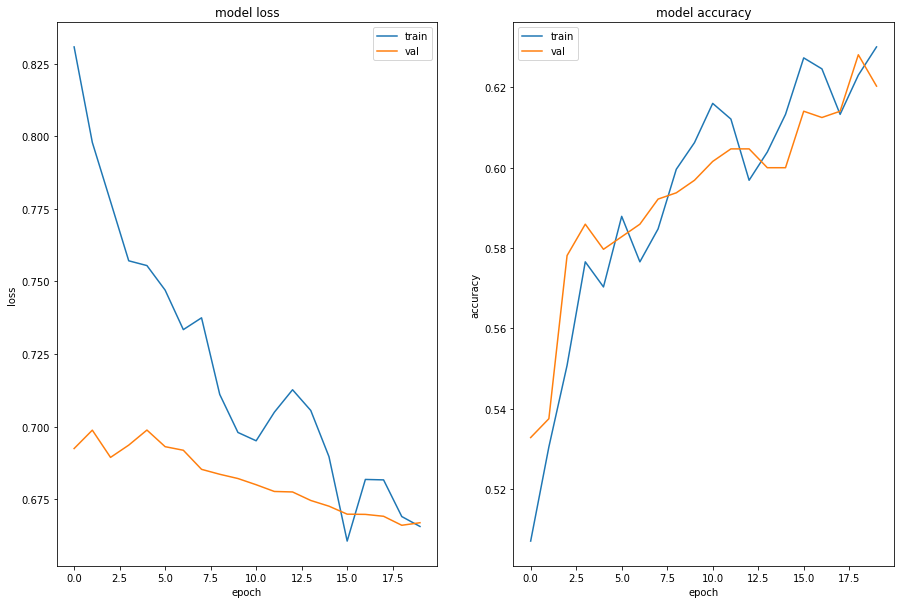

In [ ]:
model_history = run_model(model, 16, 20)
plot_training_graph(model_history)

as we can see, the model didn't get improvment and even looks underfit since the model had performed about the same on the validation set in both loss and accuracy. 

second try:

In [ ]:
model_2 = keras.Sequential()
model_2.add(Conv2D(16, (3,3), input_shape=(180,180,3)))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2,2)))

model_2.add(Conv2D(16, (3,3)))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2,2)))

model_2.add(Conv2D(32, (3,3)))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2,2)))

model_2.add(Conv2D(32, (3,3)))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2,2)))


model_2.add(Flatten())

model_2.add(Dense(64))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))

# reduce the dropout because the model had a hard time learning the train set
# in the beginning val accuracy was way bigger
model_2.add(Dropout(0.3)) 
model_2.add(Dense(1))
model_2.add(Activation('sigmoid'))

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 178, 178, 16)      448       
                                                                 
 batch_normalization_11 (Bat  (None, 178, 178, 16)     64        
 chNormalization)                                                
                                                                 
 activation_13 (Activation)  (None, 178, 178, 16)      0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 89, 89, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 87, 87, 16)        2320      
                                                                 
 batch_normalization_12 (Bat  (None, 87, 87, 16)      

Epoch 1/20
320/320 [==============================] - 7s 17ms/step - loss: 0.7550 - accuracy: 0.5500 - val_loss: 0.7190 - val_accuracy: 0.5437 - lr: 1.0000e-05
Epoch 2/20
320/320 [==============================] - 5s 15ms/step - loss: 0.7222 - accuracy: 0.5621 - val_loss: 0.6583 - val_accuracy: 0.5953 - lr: 1.0000e-05
Epoch 3/20
320/320 [==============================] - 6s 17ms/step - loss: 0.7020 - accuracy: 0.5902 - val_loss: 0.6531 - val_accuracy: 0.6219 - lr: 1.0000e-05
Epoch 4/20
320/320 [==============================] - 5s 16ms/step - loss: 0.6946 - accuracy: 0.5785 - val_loss: 0.6535 - val_accuracy: 0.6281 - lr: 1.0000e-05
Epoch 5/20
320/320 [==============================] - 5s 16ms/step - loss: 0.6694 - accuracy: 0.6156 - val_loss: 0.6447 - val_accuracy: 0.6422 - lr: 1.0000e-05
Epoch 6/20
320/320 [==============================] - 6s 18ms/step - loss: 0.6691 - accuracy: 0.6160 - val_loss: 0.6378 - val_accuracy: 0.6328 - lr: 1.0000e-05
Epoch 7/20
320/320 [====================

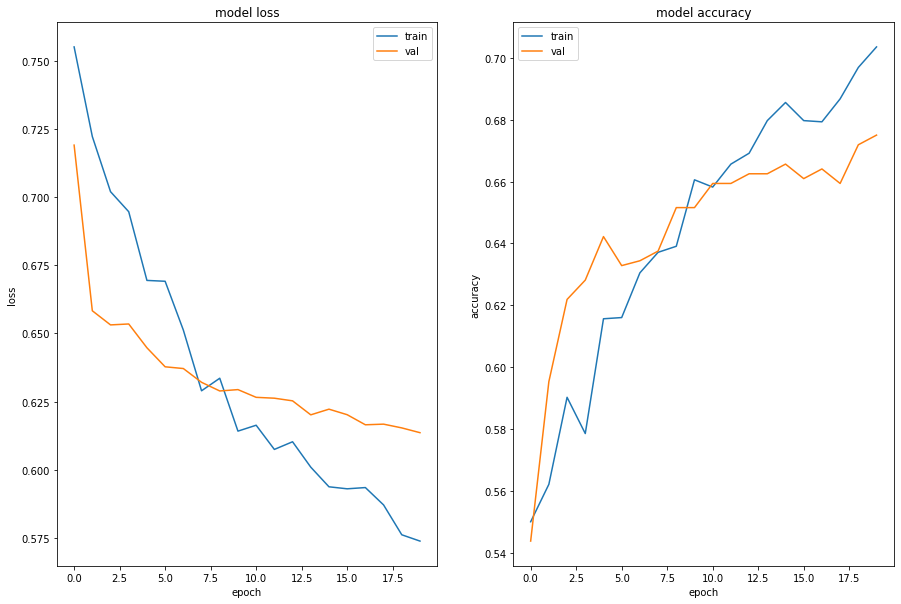

In [ ]:
# reduce the batch size from 16 to 8, to reduce the model generalization error
model_2_history = run_model(model_2, 8, 20)
plot_training_graph(model_2_history)

Because the previous model was underfit, we have reduced the dropout, and now the model is still underfit.

Third try - a relatively deep model:

In [ ]:
model_3 = keras.Sequential()
model_3.add(Conv2D(64, (3,3), input_shape=(180,180,3)))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))

model_3.add(Conv2D(64, (3,3)))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2,2)))

model_3.add(Conv2D(128, (3,3)))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))

model_3.add(Conv2D(128, (3,3)))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))

model_3.add(Conv2D(128, (3,3)))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2,2)))

model_3.add(Conv2D(128, (3,3)))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))

model_3.add(Conv2D(128, (3,3)))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))

model_3.add(Conv2D(128, (3,3)))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2,2)))


model_3.add(Flatten(name='flatten'))
  
model_3.add(Dense(512))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.5))
  
model_3.add(Dense(512))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.5))

model_3.add(Dense(1))
model_3.add(Activation('sigmoid'))

model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 178, 178, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 178, 178, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 176, 176, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 176, 176, 64)      0

Epoch 1/20
160/160 [==============================] - 57s 270ms/step - loss: 0.9135 - accuracy: 0.5312 - val_loss: 0.7109 - val_accuracy: 0.5109 - lr: 1.0000e-05
Epoch 2/20
160/160 [==============================] - 45s 284ms/step - loss: 0.7410 - accuracy: 0.5543 - val_loss: 0.7240 - val_accuracy: 0.5109 - lr: 1.0000e-05
Epoch 3/20
160/160 [==============================] - 45s 281ms/step - loss: 0.6752 - accuracy: 0.6109 - val_loss: 0.6763 - val_accuracy: 0.5672 - lr: 1.0000e-05
Epoch 4/20
160/160 [==============================] - 43s 267ms/step - loss: 0.6606 - accuracy: 0.6137 - val_loss: 0.6455 - val_accuracy: 0.6328 - lr: 1.0000e-05
Epoch 5/20
160/160 [==============================] - 43s 266ms/step - loss: 0.6384 - accuracy: 0.6238 - val_loss: 0.6446 - val_accuracy: 0.6125 - lr: 1.0000e-05
Epoch 6/20
160/160 [==============================] - 43s 267ms/step - loss: 0.6021 - accuracy: 0.6734 - val_loss: 0.6580 - val_accuracy: 0.6297 - lr: 1.0000e-05
Epoch 7/20
160/160 [========

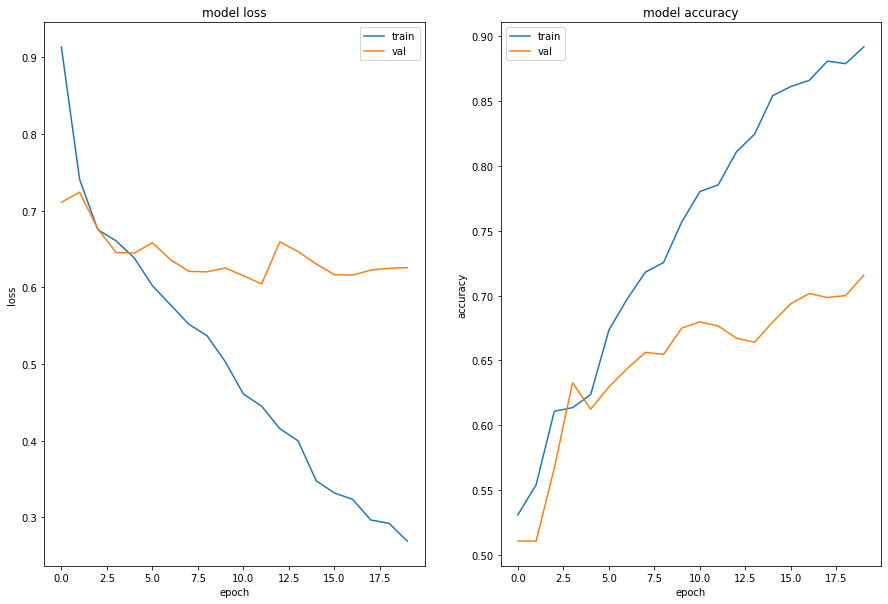

In [ ]:
model_3_history = run_model(model_3, 16, 20)
plot_training_graph(model_3_history)

This is the best model so far. It looks like it started overfitting around the 10th epoch, but it did not converge on 20 epochs alone so we believe we can stil say it was a good run.

P.S - We didn't expect a model who learns 20M parameters to converge in any way after only 20 epochs.

## Part 3 - Transfer Learning  
We have loaded the Xception pre-trained model from keras and added  a fully-connected layer on top of the trained model and trained it again. let's see the results:

In [ ]:
# Create base model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(180, 180, 3),
    include_top=False)

# Freeze base model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(180, 180, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = Dense(1)(x)
transfer_model = keras.Model(inputs, outputs)
transfer_model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 xception (Functional)       (None, 6, 6, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_3 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_________________________________________________________________


Epoch 1/30
160/160 [==============================] - 27s 142ms/step - loss: 4.5748 - accuracy: 0.5379 - val_loss: 3.4056 - val_accuracy: 0.5891 - lr: 1.0000e-05
Epoch 2/30
160/160 [==============================] - 22s 135ms/step - loss: 2.8365 - accuracy: 0.5820 - val_loss: 2.1318 - val_accuracy: 0.6297 - lr: 1.0000e-05
Epoch 3/30
160/160 [==============================] - 23s 142ms/step - loss: 2.2278 - accuracy: 0.6102 - val_loss: 2.0109 - val_accuracy: 0.6375 - lr: 1.0000e-05
Epoch 4/30
160/160 [==============================] - 23s 141ms/step - loss: 1.9645 - accuracy: 0.6301 - val_loss: 1.8290 - val_accuracy: 0.6516 - lr: 1.0000e-05
Epoch 5/30
160/160 [==============================] - 23s 142ms/step - loss: 1.7857 - accuracy: 0.6527 - val_loss: 1.6026 - val_accuracy: 0.6766 - lr: 1.0000e-05
Epoch 6/30
160/160 [==============================] - 22s 135ms/step - loss: 1.6259 - accuracy: 0.6707 - val_loss: 1.5500 - val_accuracy: 0.6828 - lr: 1.0000e-05
Epoch 7/30
160/160 [========

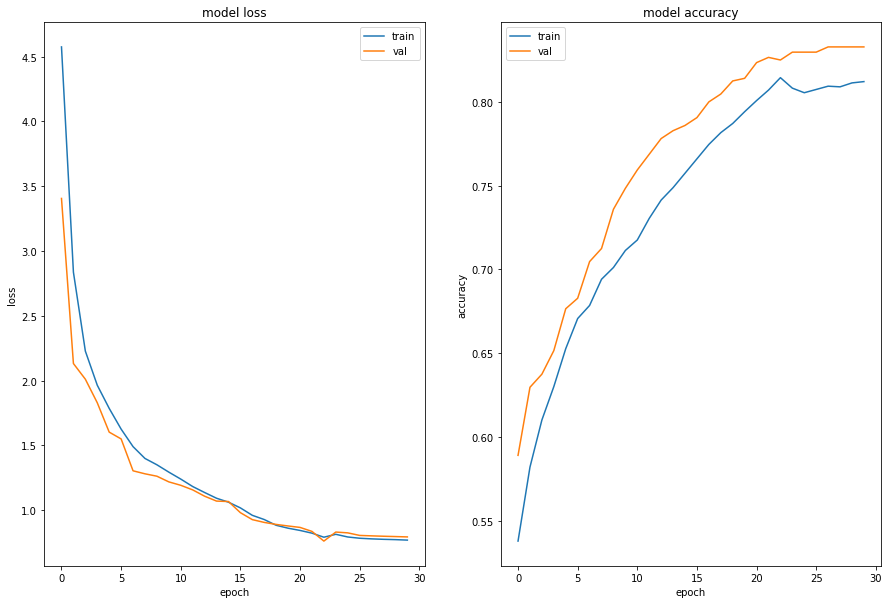

In [ ]:
transfer_model_history = run_model(transfer_model, 16, 30)
plot_training_graph(transfer_model_history)

In [ ]:
# get accuracies
_, basic_cnn_model_test_acc = basic_cnn_model.evaluate(X_test,Y_test, verbose=0)
_, my_model_test_acc = model_3.evaluate(X_test,Y_test, verbose=0)
_, trsnsfer_model_test_acc = transfer_model.evaluate(X_test,Y_test, verbose=0)

_, basic_cnn_model_train_acc = basic_cnn_model.evaluate(X_train,Y_train, verbose=0)
_, my_model_train_acc = model_3.evaluate(X_train,Y_train, verbose=0)
_, trsnsfer_model_train_acc = transfer_model.evaluate(X_train,Y_train, verbose=0)


In [ ]:
results = {'model': ['Basic CNN', 'My Model', 'Name of pre-trained model from keras applications'],
           'Test score (Accuracy)': [basic_cnn_model_test_acc, my_model_test_acc, trsnsfer_model_test_acc ],
           'Train score (Accuracy)': [basic_cnn_model_train_acc, my_model_train_acc, trsnsfer_model_train_acc],
           'Number of trainable parameters': ['697,185', '20,055,873', '2,049'],
           'Number of layers': [len(basic_cnn_model.layers),len(model_3.layers),len(transfer_model.layers)],
           'Regularization methods': ['batch normalization, dropout', 'batch normalization, dropout', 'batch normalization, dropout'],
           'Number of epochs': [30, 20, 30], # not final
           'Loss function': ['binary crossentropy', 'binary crossentropy' , 'binary crossentropy'],
           'Optimizer': ['Adam', 'Adam', 'Adam']
           }

results_df = pd.DataFrame(results)
results_df

,model,Test score (Accuracy),Train score (Accuracy),Number of trainable parameters,Number of layers,Regularization methods,Number of epochs,Loss function,Optimizer
0,Basic CNN,0.74375,0.941016,"697,185",23,"batch normalization, dropout",30,binary crossentropy,Adam
1,My Model,0.78375,0.964063,"20,055,873",36,"batch normalization, dropout",20,binary crossentropy,Adam
2,Name of pre-trained model from keras applications,0.80750,0.813281,"2,049",4,"batch normalization, dropout",30,binary crossentropy,Adam


In [ ]:
path_to_save = 'drive/My Drive/EX2_MICHAEL_RUBINFELD_AND_DALIA_SMYRNOV/exercise2.csv'
results_df.to_csv(path_to_save)